In [1]:
# Data preparation for Ph.D thesis
# copy from INDICATORS_DATASET_RAW_DATA_FOR_TS-GENERATOR-PARSING.ipynb
# @author: Andres L. Suarez-Cetrulo
%config IPCompleter.greedy=True
%load_ext jupyternotify
%matplotlib inline

<IPython.core.display.Javascript object>

In [2]:
# Imports
import pandas as pd
import numpy as np
import datetime
from pathlib import Path
import os
import matplotlib.pyplot as plt

# Using TALib abstract API to create a dictionary of technical indicators to iterate later.
from talib import abstract

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
def get_fullpath(filename: str):
    return os.sep.join(['C:','Users','suare','data', 'raw', 'quantquote', 'minutes', filename])

file = 'spy_historical.csv'
# filepath = os.sep.join(['C:','Users','suare','data', 'raw', 'quantquote', 'minutes', file])
filepath = get_fullpath(file)

In [5]:
df = pd.read_csv(filepath)
df.drop(columns=['splits', 'earnings', 'dividends'], errors='ignore', inplace=True)
df.head()

,date,time,open,high,low,close,volume
0,19980102,931,64.9236,64.9236,64.9236,64.9236,97424.60
1,19980102,932,65.0103,65.0103,64.9236,64.9436,31325.70
2,19980102,933,65.0503,65.0503,64.9436,65.0303,32075.20
3,19980102,934,64.9703,64.9703,64.9703,64.9703,1498.84
4,19980102,935,65.0170,65.0303,64.9703,64.9703,17536.40


# 1. Let's split the set in Mahab, Dev and Train sets.

In [6]:
# Declaring list of files to be parsed afterwards
files = list()

In [7]:
mahab_years = ['2008', '2009']  # add years as str
mahab_yr_name = pd.Series(mahab_years).apply(lambda x: x[-2:])
mahab_subset_df = df[df.date.astype(str).str[:4].isin(mahab_years)]

mahab_months = dict() # one pos per state
mahab_months['state_1'] = ['200810','200811','200812'] # bear trend Q4 2008
mahab_months['state_2'] = ['200904','200905','200906'] # bull trend Q2 2009 
mahab_months['state_3'] = ['200910','200911','200912'] # lateral trend Q4 2009

mahab_state_dfs = dict() # one df per state
for state, months in mahab_months.items():
    mahab_state_dfs[state] = \
        mahab_subset_df[mahab_subset_df.date.astype(str).str[:6].isin(mahab_months[state])]
    filename = f'spy_mahab_{"-".join(mahab_yr_name)}_{state}.csv'
    mahab_state_dfs[state].to_csv(get_fullpath(filename), index=False)
    files.append(filename)

In [8]:
devset_years = ['2010']  # add years as str
devset_subset_df = df[df.date.astype(str).str[:4].isin(devset_years)]
filename = f'spy_devset_{"-".join(devset_years)}.csv'
devset_subset_df.to_csv(get_fullpath(filename), index=False)
files.append(filename)

In [9]:
from_yr = 2011  # as int
to_yr = 2020    # as int
trainset_years = list(pd.Series(range(from_yr, to_yr + 1, 1)).astype(str))  # add years as str
trainset_subset_df = df[df.date.astype(str).str[:4].isin(trainset_years)]
filename = f'spy_trainset_{from_yr}-{to_yr}.csv'
trainset_subset_df.to_csv(get_fullpath(filename), index=False)
files.append(filename)

In [10]:
trainset_subset_df.head()

,date,time,open,high,low,close,volume
1245406,20110103,930,105.114,105.138,105.072,105.122,3538420.0
1245407,20110103,931,105.122,105.180,105.097,105.180,1039570.0
1245408,20110103,932,105.180,105.197,105.130,105.147,727576.0
1245409,20110103,933,105.147,105.188,105.130,105.138,554285.0
1245410,20110103,934,105.138,105.155,105.130,105.155,751152.0


In [11]:
files

['spy_mahab_08-09_state_1.csv',
 'spy_mahab_08-09_state_2.csv',
 'spy_mahab_08-09_state_3.csv',
 'spy_devset_2010.csv',
 'spy_trainset_2011-2020.csv']

# 2. Now let's use these datasets and deal with gaps so they're ready for the technical indicators.

In [12]:
files

['spy_mahab_08-09_state_1.csv',
 'spy_mahab_08-09_state_2.csv',
 'spy_mahab_08-09_state_3.csv',
 'spy_devset_2010.csv',
 'spy_trainset_2011-2020.csv']

In [17]:
sources = ['S&P500']
levels = ['1min-level', '5min-level', '10min-level', '15min-level', '30min-level', '1h-level']

files_for_indicators = list()
for source in sources:
    print(source)
    for file in files: # ['spy_historical']: # files considers devsets and all mahalnobis state specific sets.
        print(f'\n= Processing file {file} =\n')
        for level in levels:
            path = os.sep.join(['C:','Users','suare','data', 'raw', 'quantquote', 'minutes', file])  # new - moving data across
#             df = pd.read_csv(path+'.csv', sep=',')  # csv does not need to be in there
            print(f'{level}')
            path = path.replace('.csv', '')
            df = pd.read_csv(path+'.csv', sep=',')
    #         df.rename(columns={'Date':'datetime'}, inplace=True)
    #         assert False
            grouped_df = df.groupby(df.date).max()
    #         early_close_dates = grouped_df[grouped_df['time'] < 1530].reset_index().date # to filter them out
    #         df = df[~df['date'].isin(early_close_dates)]  # this has minimum impact anyway...
            df['date'] =  pd.to_datetime(df['date'], format='%Y%m%d').dt.strftime('%Y-%m-%d')
            df['time'] = (pd.to_datetime(df['time'].astype(str).str.strip(), format='%H%M').dt.strftime('%H:%M'))
            df['datetime'] = df.date.astype(str) + ' ' + df.time.astype(str)
    #         assert False
            trading_dates = df.datetime.str[:10].unique() #  list of market days
            df.index = pd.to_datetime(df.datetime)
            df.drop(columns=['date', 'time', 'datetime', 'splits', 'earnings', 'dividends'], 
                    errors='ignore', inplace=True)    
            df.sort_index(inplace=True, ascending=True)
            print(f' - Original size: {len(df)}')
            ohlc_dict = {'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume': 'sum'}
            df = df.resample(level.split('-')[0]).agg(ohlc_dict)
            print(f' - Size after resampling at {level}: {len(df)}')
            df = df.between_time('09:31','15:59')
            print(f' - Size after filtering out non-market hours: {len(df)}')
            df = df[df.index.astype(str).str[:10].isin(trading_dates)]
            # TODO? (low impact..) df = df.between_time('09:31','13:00') for half days (shortened sessions / early closing)
            print(f' - Size after filtering out non-trading days: {len(df)}')
            # Fill gaps
            df['volume'] = df['volume'].fillna(0)
            df['close'] = df['close'].ffill()
            df['open'] = df['open'].fillna(df['close'])
            df['low'] = df['low'].fillna(df['close'])
            df['high'] = df['high'].fillna(df['close'])
            path = os.sep.join(['C:','Users','suare','PycharmProjects','RegimeSwitchingSeriesGenerator','data','efts',level,source])
            Path(path).mkdir(parents=True, exist_ok=True) # create dir if it does not exist
            full_path = path + os.sep + '_'.join([file.replace('.csv', ''), 'filling_gaps', 'market_hours', '21.csv'])
            df.to_csv(full_path, sep=';')
    #         os.remove(full_path)
            print(f' - Output path: {full_path} \n========================')
            files_for_indicators.append(full_path)
# files

S&P500

= Processing file spy_mahab_08-09_state_1.csv =

1min-level
 - Original size: 24788
 - Size after resampling at 1min-level: 131430
 - Size after filtering out non-market hours:35788
 - Size after filtering out non-trading days: 24896
 - Output path: C:\Users\suare\PycharmProjects\RegimeSwitchingSeriesGenerator\data\efts\1min-level\S&P500\spy_mahab_08-09_state_1_filling_gaps_market_hours_21.csv 
5min-level
 - Original size: 24788
 - Size after resampling at 5min-level: 26286
 - Size after filtering out non-market hours:7084
 - Size after filtering out non-trading days: 4928
 - Output path: C:\Users\suare\PycharmProjects\RegimeSwitchingSeriesGenerator\data\efts\5min-level\S&P500\spy_mahab_08-09_state_1_filling_gaps_market_hours_21.csv 
10min-level
 - Original size: 24788
 - Size after resampling at 10min-level: 13143
 - Size after filtering out non-market hours:3496
 - Size after filtering out non-trading days: 2432
 - Output path: C:\Users\suare\PycharmProjects\RegimeSwitchingSe

30min-level
 - Original size: 98260
 - Size after resampling at 30min-level: 17341
 - Size after filtering out non-market hours:4344
 - Size after filtering out non-trading days: 3024
 - Output path: C:\Users\suare\PycharmProjects\RegimeSwitchingSeriesGenerator\data\efts\30min-level\S&P500\spy_devset_2010_filling_gaps_market_hours_21.csv 
1h-level
 - Original size: 98260
 - Size after resampling at 1h-level: 8671
 - Size after filtering out non-market hours:2172
 - Size after filtering out non-trading days: 1512
 - Output path: C:\Users\suare\PycharmProjects\RegimeSwitchingSeriesGenerator\data\efts\1h-level\S&P500\spy_devset_2010_filling_gaps_market_hours_21.csv 

= Processing file spy_trainset_2011-2020.csv =

1min-level
 - Original size: 923860
 - Size after resampling at 1min-level: 4955430
 - Size after filtering out non-market hours:1338938
 - Size after filtering out non-trading days: 922708
 - Output path: C:\Users\suare\PycharmProjects\RegimeSwitchingSeriesGenerator\data\efts\1

In [30]:
files_for_indicators

['C:\\Users\\suare\\PycharmProjects\\RegimeSwitchingSeriesGenerator\\data\\efts\\1min-level\\S&P500\\spy_mahab_08-09_state_1_filling_gaps_market_hours_21.csv',
 'C:\\Users\\suare\\PycharmProjects\\RegimeSwitchingSeriesGenerator\\data\\efts\\5min-level\\S&P500\\spy_mahab_08-09_state_1_filling_gaps_market_hours_21.csv',
 'C:\\Users\\suare\\PycharmProjects\\RegimeSwitchingSeriesGenerator\\data\\efts\\10min-level\\S&P500\\spy_mahab_08-09_state_1_filling_gaps_market_hours_21.csv',
 'C:\\Users\\suare\\PycharmProjects\\RegimeSwitchingSeriesGenerator\\data\\efts\\15min-level\\S&P500\\spy_mahab_08-09_state_1_filling_gaps_market_hours_21.csv',
 'C:\\Users\\suare\\PycharmProjects\\RegimeSwitchingSeriesGenerator\\data\\efts\\30min-level\\S&P500\\spy_mahab_08-09_state_1_filling_gaps_market_hours_21.csv',
 'C:\\Users\\suare\\PycharmProjects\\RegimeSwitchingSeriesGenerator\\data\\efts\\1h-level\\S&P500\\spy_mahab_08-09_state_1_filling_gaps_market_hours_21.csv',
 'C:\\Users\\suare\\PycharmProjects\\Re

In [19]:
import subprocess
# Define this to parse the CSVs to ARFF later automatically
def create_arff_file(filename, output=None):
    java_mem = '-Xmx3074m'
    filename = filename.replace('.csv', '')
    if output is None:
        output=filename
    else:
        output = output.replace('.csv', '')
    wekadev_libpath = 'C:\\Users\\suare\\Workspace\\phd_cetrulin\\moa-2017.06-sources\\lib\\weka-dev-3.7.12.jar'
    command = ['java', java_mem, '-classpath', wekadev_libpath,
               'weka.core.converters.CSVLoader', filename + '.csv', '>', output + '.arff']
    f = open(filename + '.arff', "w")
    subprocess.call(command, stdout=f)
    print('If the arff is not generated, run the next in the terminal.')
    print(str(' '.join(command)))

#### Now let's define indicators, paths, and start the transformation process


In [20]:
# Creating a dictionary of technical indicators using TALib abstract API
indicators = ['sma','ema','wma','mom','stoch','macd' ,'rsi' ,'willr',
              'adosc' ,'cci','adx','aroon' ,'bbands','obv' ,'trima',
              'roc' ,'rocr','stochf','medprice','typprice','wclprice',
              'atr','macdfix','mfi' ,'sar' ,'ppo']

def get_indicator(ind: str):
    return abstract.Function(ind)

# Add as many indicators as necessary: see all indicators in https://mrjbq7.github.io/ta-lib/

In [23]:
pd.Series(files).apply(lambda x: x.replace('.csv', ''))

0    spy_mahab_08-09_state_1
1    spy_mahab_08-09_state_2
2    spy_mahab_08-09_state_3
3            spy_devset_2010
4     spy_trainset_2011-2020
dtype: object

Start spy_mahab_08-09_state_1_filling_gaps_market_hours_21.csv
              datetime     open     high      low    close     volume
0  2008-10-01 09:31:00  90.8588  90.8746  90.7011  90.7090  1377100.0
1  2008-10-01 09:32:00  90.7090  90.7879  90.6932  90.7405  1230160.0
2  2008-10-01 09:33:00  90.7326  90.7642  90.7090  90.7405   990501.0
3  2008-10-01 09:34:00  90.7405  90.7642  90.5907  90.5985  1202520.0
4  2008-10-01 09:35:00  90.5985  90.6459  90.5670  90.5828  1309760.0
             datetime     open     high      low    close     volume  \
0 2008-10-01 10:05:00  90.2278  90.3225  90.1174  90.1884  1676150.0   
1 2008-10-01 10:06:00  90.1884  90.2199  90.0070  90.0937  1886200.0   
2 2008-10-01 10:07:00  90.1016  90.2121  90.0780  90.1963  1176430.0   
3 2008-10-01 10:08:00  90.1963  90.2909  90.1884  90.2042   720000.0   
4 2008-10-01 10:09:00  90.2042  90.2121  90.1016  90.1332   851841.0   

   close_t-1  close_t-2  close_t-3  close_t-4  ...     sar_10    ppo_10  \
0    90.2

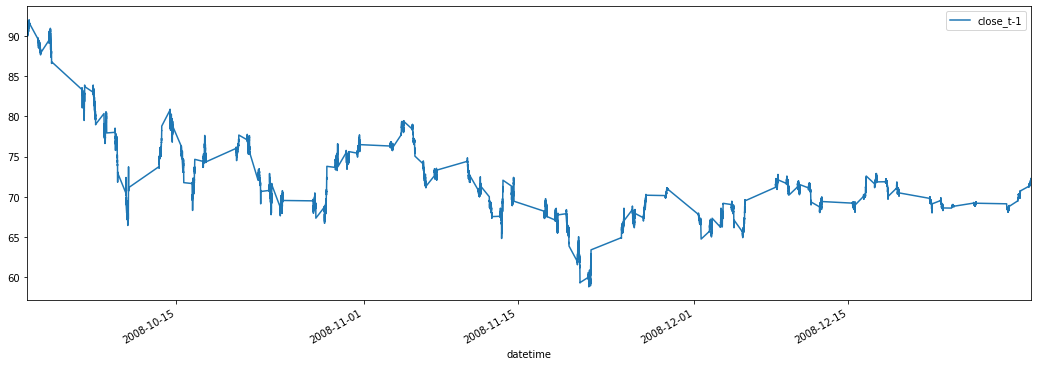

Number of instances: 22656
Class distribution: 
0 in 0.5310734463276836%
1 in 0.4689265536723164%


<IPython.core.display.Javascript object>

Start spy_mahab_08-09_state_1_filling_gaps_market_hours_21.csv
              datetime     open     high      low    close     volume
0  2008-10-01 09:35:00  90.5985  90.6459  90.3225  90.3461  6066000.0
1  2008-10-01 09:40:00  90.3461  90.8825  90.3382  90.8431  6758813.0
2  2008-10-01 09:45:00  90.8352  91.0403  90.8036  90.8746  8608398.0
3  2008-10-01 09:50:00  90.8746  90.8746  90.6459  90.7247  3484576.0
4  2008-10-01 09:55:00  90.7169  90.9772  90.6774  90.9219  3086975.0
             datetime     open     high      low    close     volume  \
0 2008-10-01 12:20:00  91.0008  91.1270  90.8746  91.1034  3380195.0   
1 2008-10-01 12:25:00  91.1034  91.1665  90.9535  91.0797  3272679.0   
2 2008-10-01 12:30:00  91.0797  91.5687  91.0324  91.5214  8320666.0   
3 2008-10-01 12:35:00  91.5214  91.6713  91.4583  91.4899  4683005.0   
4 2008-10-01 12:40:00  91.4899  91.6871  91.4268  91.4346  5525828.0   

   close_t-1  close_t-2  close_t-3  close_t-4  ...     sar_10    ppo_10  \
0    91.0

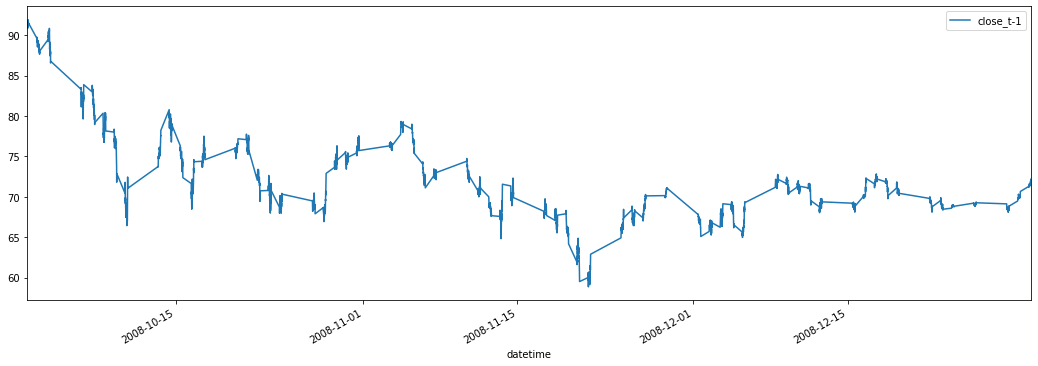

Number of instances: 4516
Class distribution: 
0 in 0.5221434898139947%
1 in 0.47785651018600533%


<IPython.core.display.Javascript object>

Start spy_mahab_08-09_state_1_filling_gaps_market_hours_21.csv
              datetime     open     high      low    close      volume
0  2008-10-01 09:40:00  90.3461  91.0403  90.3382  90.8746  15367211.0
1  2008-10-01 09:50:00  90.8746  90.9772  90.6459  90.9219   6571551.0
2  2008-10-01 10:00:00  90.9141  90.9298  90.0070  90.1332  15399333.0
3  2008-10-01 10:10:00  90.1332  90.4487  89.9675  90.4329  10157998.0
4  2008-10-01 10:20:00  90.4329  90.5433  90.3225  90.4723   8124848.0
             datetime     open     high      low    close      volume  \
0 2008-10-01 15:10:00  91.5372  91.7975  91.1744  91.3637   7904104.0   
1 2008-10-01 15:20:00  91.3637  91.5530  91.2611  91.4110   4608017.0   
2 2008-10-01 15:30:00  91.4189  91.6555  91.2848  91.3715   6783699.0   
3 2008-10-01 15:40:00  91.3715  91.6318  91.2927  91.3558   7525016.0   
4 2008-10-01 15:50:00  91.3558  91.6713  91.3163  91.4899  12618125.0   

   close_t-1  close_t-2  close_t-3  close_t-4  ...     sar_10    ppo_10 

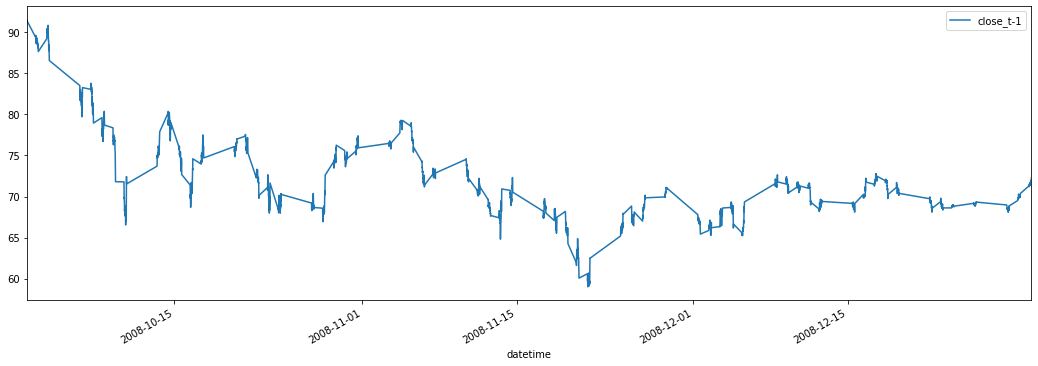

Number of instances: 2209
Class distribution: 
0 in 0.5196921684019918%
1 in 0.48030783159800816%


<IPython.core.display.Javascript object>

Start spy_mahab_08-09_state_1_filling_gaps_market_hours_21.csv
              datetime     open     high      low    close      volume
0  2008-10-01 09:45:00  90.8352  91.0403  90.6459  90.9219  15179949.0
1  2008-10-01 10:00:00  90.9141  90.9298  89.9675  90.2988  20928953.0
2  2008-10-01 10:15:00  90.3067  90.5433  90.0701  90.4723  12753226.0
3  2008-10-01 10:30:00  90.4802  90.5039  90.0701  90.1568  10846906.0
4  2008-10-01 10:45:00  90.1568  90.2830  89.9281  90.1963   9947990.0
             datetime     open     high      low    close     volume  \
0 2008-10-02 11:45:00  89.1630  89.3286  89.0289  89.2734  8448076.0   
1 2008-10-02 12:00:00  89.2655  89.5022  89.0999  89.1945  8992629.0   
2 2008-10-02 12:15:00  89.2024  89.4154  88.9342  88.9894  7203747.0   
3 2008-10-02 12:30:00  88.9894  89.0841  88.8554  88.8790  7591208.0   
4 2008-10-02 12:45:00  88.8869  89.1788  88.8080  89.0447  7307782.0   

   close_t-1  close_t-2  close_t-3  close_t-4  ...     sar_10    ppo_10  \
0  

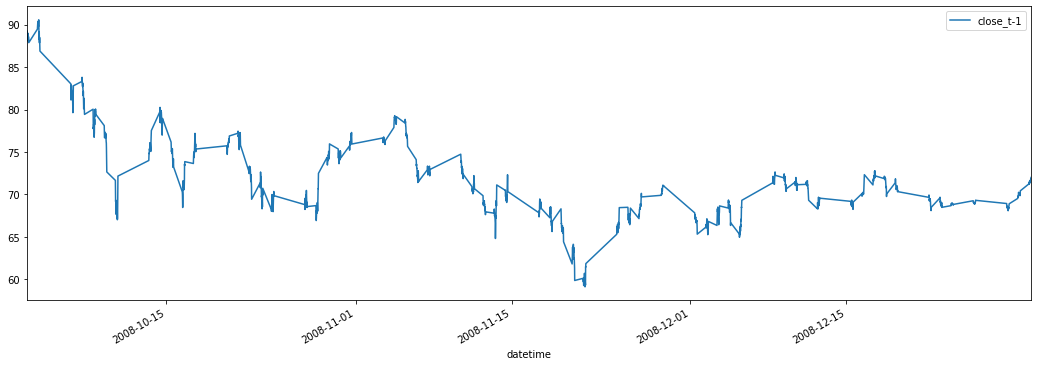

Number of instances: 1442
Class distribution: 
0 in 0.5180305131761442%
1 in 0.48196948682385576%


<IPython.core.display.Javascript object>

Start spy_mahab_08-09_state_1_filling_gaps_market_hours_21.csv
              datetime     open     high      low    close      volume
0  2008-10-01 10:00:00  90.9141  90.9298  89.9675  90.4723  33682179.0
1  2008-10-01 10:30:00  90.4802  90.5039  89.9281  90.1963  20794896.0
2  2008-10-01 11:00:00  90.1884  90.6222  89.8808  90.5433  18969400.2
3  2008-10-01 11:30:00  90.5433  90.8115  90.4092  90.6538  17973853.0
4  2008-10-01 12:00:00  90.6538  91.2138  90.4881  91.0797  21949996.0
             datetime     open     high      low    close      volume  \
0 2008-10-03 14:30:00  87.8536  88.5951  87.2147  88.5004  58044535.0   
1 2008-10-03 15:00:00  88.5004  88.7449  87.3961  87.6485  32088523.0   
2 2008-10-03 15:30:00  87.6485  88.1455  86.5127  86.7414  54772387.0   
3 2008-10-06 10:30:00  82.6240  82.6635  80.8730  82.3006  64711260.0   
4 2008-10-06 11:00:00  82.3085  83.3103  82.1192  82.8607  56128950.0   

   close_t-1  close_t-2  close_t-3  close_t-4  ...     sar_10    ppo_10 

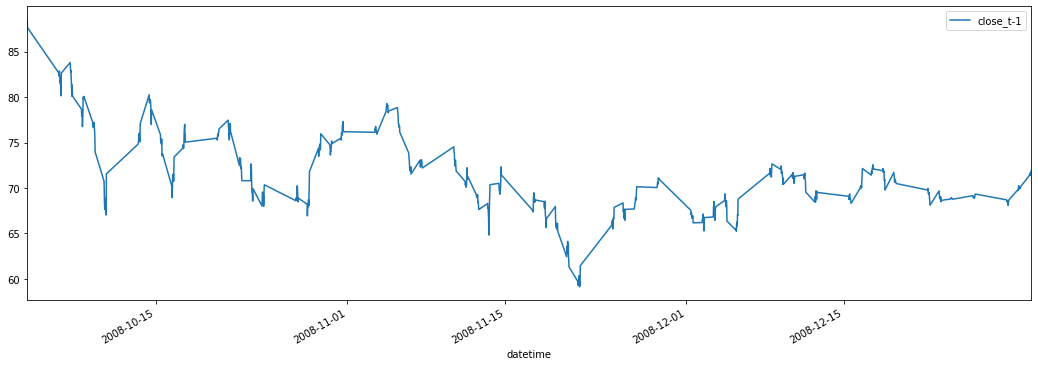

Number of instances: 673
Class distribution: 
0 in 0.5230312035661219%
1 in 0.4769687964338782%


<IPython.core.display.Javascript object>

Start spy_mahab_08-09_state_1_filling_gaps_market_hours_21.csv
              datetime     open     high      low    close      volume
0  2008-10-01 10:00:00  90.9141  90.9298  89.9281  90.1963  54477075.0
1  2008-10-01 11:00:00  90.1884  90.8115  89.8808  90.6538  36943253.2
2  2008-10-01 12:00:00  90.6538  92.0026  90.4881  91.6634  59127956.0
3  2008-10-01 13:00:00  91.6634  91.7975  90.5039  91.1744  82107301.0
4  2008-10-01 14:00:00  91.1665  92.0420  90.8352  91.4977  58405650.0
             datetime     open     high      low    close       volume  \
0 2008-10-08 13:00:00  77.2762  80.1710  77.2525  79.9974  110568322.0   
1 2008-10-08 14:00:00  79.9974  80.5969  79.0982  79.8318   90382667.0   
2 2008-10-08 15:00:00  79.8239  80.5890  77.4181  77.6153  135614800.0   
3 2008-10-09 11:00:00  76.6767  77.9308  75.6671  76.8739   92044317.0   
4 2008-10-09 12:00:00  76.8660  77.4655  76.2665  76.6294   34606429.0   

   close_t-1  close_t-2  close_t-3  close_t-4  ...     sar_10    p

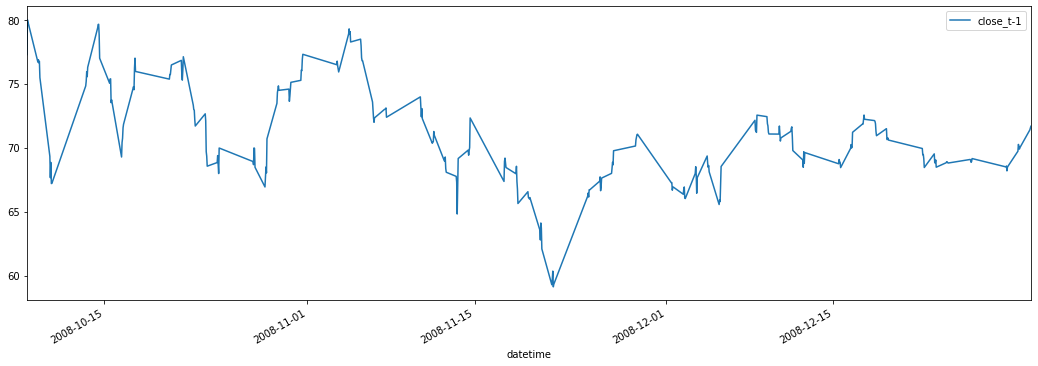

Number of instances: 292
Class distribution: 
0 in 0.5136986301369864%
1 in 0.4863013698630137%


<IPython.core.display.Javascript object>

Start spy_mahab_08-09_state_2_filling_gaps_market_hours_21.csv
              datetime     open     high      low    close     volume
0  2009-04-01 09:31:00  62.9242  62.9643  62.8041  62.8121  1703640.0
1  2009-04-01 09:32:00  62.8121  62.8521  62.7720  62.8361  1328410.0
2  2009-04-01 09:33:00  62.8361  62.8922  62.7961  62.8281  1351580.0
3  2009-04-01 09:34:00  62.8281  62.8441  62.7400  62.7480  1830900.0
4  2009-04-01 09:35:00  62.7400  62.9002  62.7320  62.8842  1378030.0
             datetime     open     high      low    close     volume  \
0 2009-04-01 10:05:00  63.4608  63.5008  63.3567  63.5008  1834260.0   
1 2009-04-01 10:06:00  63.5089  63.5169  63.3647  63.3807  1077720.0   
2 2009-04-01 10:07:00  63.3807  63.5329  63.3487  63.4768  1193020.0   
3 2009-04-01 10:08:00  63.4848  63.5569  63.4768  63.4928  1558590.0   
4 2009-04-01 10:09:00  63.4928  63.5169  63.4528  63.5008  1045390.0   

   close_t-1  close_t-2  close_t-3  close_t-4  ...     sar_10    ppo_10  \
0    63.4

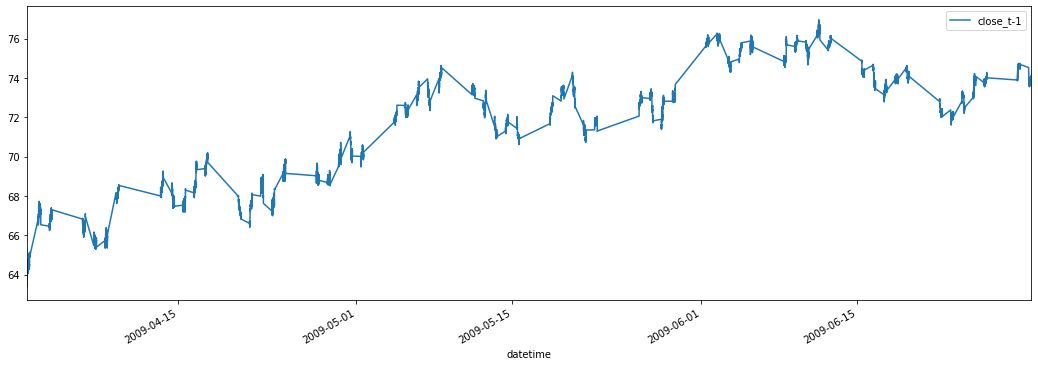

Number of instances: 22302
Class distribution: 
0 in 0.5413864227423549%
1 in 0.45861357725764507%


<IPython.core.display.Javascript object>

Start spy_mahab_08-09_state_2_filling_gaps_market_hours_21.csv
              datetime     open     high      low    close      volume
0  2009-04-01 09:35:00  62.7400  63.0123  62.7320  62.9482  10291160.0
1  2009-04-01 09:40:00  62.9482  63.0524  62.8922  62.9322   5940562.0
2  2009-04-01 09:45:00  62.9322  63.0443  62.8441  62.8601   4156901.0
3  2009-04-01 09:50:00  62.8601  62.9482  62.8441  62.9162   3976654.0
4  2009-04-01 09:55:00  62.9162  63.1885  62.8842  63.1885   5225154.0
             datetime     open     high      low    close     volume  \
0 2009-04-01 12:20:00  64.6621  64.6861  64.5820  64.6701  3775163.0   
1 2009-04-01 12:25:00  64.6621  64.6701  64.5340  64.5980  2092137.0   
2 2009-04-01 12:30:00  64.5980  64.6861  64.5740  64.5900  2357284.0   
3 2009-04-01 12:35:00  64.5820  64.5900  64.4379  64.5099  2528856.0   
4 2009-04-01 12:40:00  64.5019  64.5500  64.4699  64.4859  1021232.0   

   close_t-1  close_t-2  close_t-3  close_t-4  ...     sar_10    ppo_10  \
0  

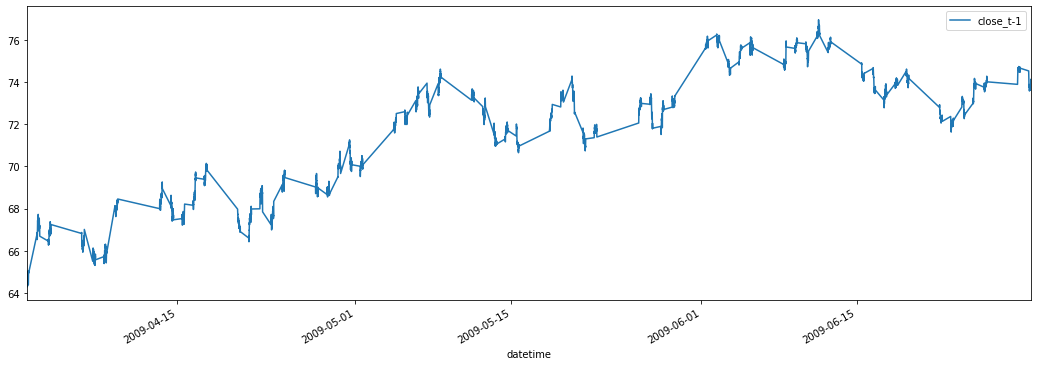

Number of instances: 4445
Class distribution: 
0 in 0.5111361079865017%
1 in 0.48886389201349834%


<IPython.core.display.Javascript object>

Start spy_mahab_08-09_state_2_filling_gaps_market_hours_21.csv
              datetime     open     high      low    close      volume
0  2009-04-01 09:40:00  62.9482  63.0524  62.8441  62.8601  10097463.0
1  2009-04-01 09:50:00  62.8601  63.1885  62.8441  63.1885   9201808.0
2  2009-04-01 10:00:00  63.1805  63.5569  63.1805  63.5008  18302730.0
3  2009-04-01 10:10:00  63.5089  63.9013  63.4928  63.8853  18080494.0
4  2009-04-01 10:20:00  63.8853  64.0935  63.8132  63.9013  18363720.0
             datetime     open     high      low    close      volume  \
0 2009-04-01 15:10:00  64.5179  64.5660  64.2136  64.4779  16329436.0   
1 2009-04-01 15:20:00  64.4939  64.6701  64.3898  64.5900   9487192.0   
2 2009-04-01 15:30:00  64.5980  65.0946  64.4298  65.0305  15594819.0   
3 2009-04-01 15:40:00  65.0305  65.1666  64.9985  65.0385  15257300.0   
4 2009-04-01 15:50:00  65.0305  65.2067  64.8143  64.8943  23581310.0   

   close_t-1  close_t-2  close_t-3  close_t-4  ...     sar_10    ppo_10 

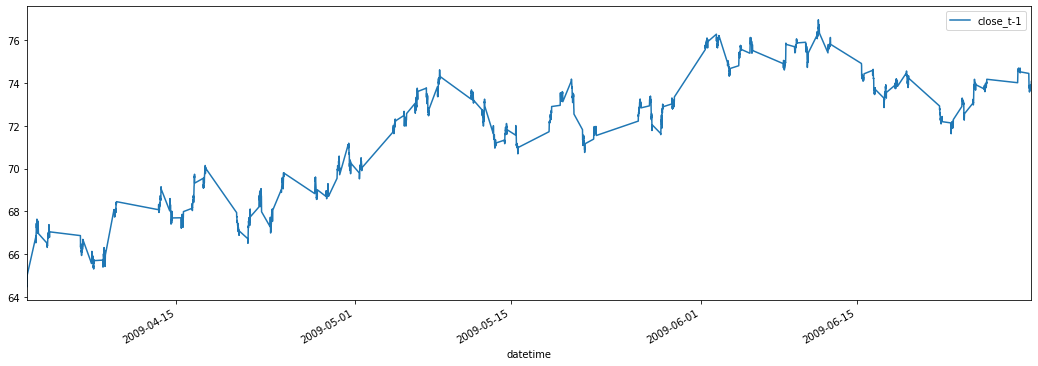

Number of instances: 2174
Class distribution: 
0 in 0.5022999080036799%
1 in 0.49770009199632015%


<IPython.core.display.Javascript object>

Start spy_mahab_08-09_state_2_filling_gaps_market_hours_21.csv
              datetime     open     high      low    close      volume
0  2009-04-01 09:45:00  62.9322  63.1885  62.8441  63.1885  13358709.0
1  2009-04-01 10:00:00  63.1805  63.6690  63.1805  63.6530  27023954.0
2  2009-04-01 10:15:00  63.6610  64.0935  63.5729  63.9013  27722990.0
3  2009-04-01 10:30:00  63.9013  64.3418  63.7491  64.2216  22349578.0
4  2009-04-01 10:45:00  64.2216  64.3978  64.1335  64.1816  25935541.0
             datetime     open     high      low    close      volume  \
0 2009-04-02 11:45:00  67.1848  67.3370  67.1368  67.2970  11640337.0   
1 2009-04-02 12:00:00  67.2970  67.3931  67.1688  67.3610   8691697.0   
2 2009-04-02 12:15:00  67.3690  67.7374  67.3690  67.6333  21319565.0   
3 2009-04-02 12:30:00  67.6333  67.7615  67.5853  67.6654  10603529.0   
4 2009-04-02 12:45:00  67.6573  67.6974  67.4091  67.4091  14465048.0   

   close_t-1  close_t-2  close_t-3  close_t-4  ...     sar_10    ppo_10 

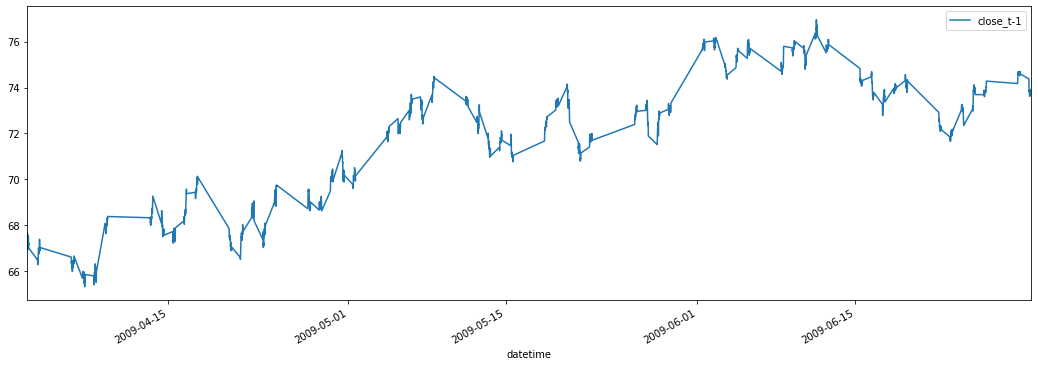

Number of instances: 1419
Class distribution: 
0 in 0.49119097956307256%
1 in 0.5088090204369274%


<IPython.core.display.Javascript object>

Start spy_mahab_08-09_state_2_filling_gaps_market_hours_21.csv
              datetime     open     high      low    close      volume
0  2009-04-01 10:00:00  63.1805  64.0935  63.1805  63.9013  54746944.0
1  2009-04-01 10:30:00  63.9013  64.3978  63.7491  64.1816  48285119.0
2  2009-04-01 11:00:00  64.1736  64.3498  63.9814  64.3017  28103720.0
3  2009-04-01 11:30:00  64.3017  64.5500  64.2296  64.4779  20026871.0
4  2009-04-01 12:00:00  64.4779  64.8063  64.4699  64.5980  23045517.0
             datetime     open     high      low    close      volume  \
0 2009-04-03 14:30:00  67.3770  67.4331  67.0887  67.2729  21140263.0   
1 2009-04-03 15:00:00  67.2649  67.2970  66.8325  66.8885  25640741.0   
2 2009-04-03 15:30:00  66.8965  67.4972  66.7283  67.4731  47516478.0   
3 2009-04-06 10:30:00  66.3359  66.5521  66.2718  66.4480  18305067.0   
4 2009-04-06 11:00:00  66.4480  66.4560  66.1517  66.3680  16053655.0   

   close_t-1  close_t-2  close_t-3  close_t-4  ...     sar_10    ppo_10 

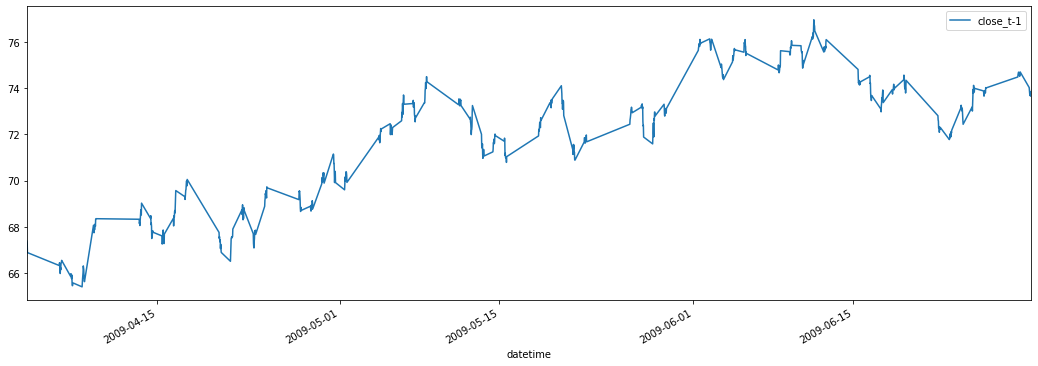

Number of instances: 662
Class distribution: 
0 in 0.4954682779456193%
1 in 0.5045317220543807%


<IPython.core.display.Javascript object>

Start spy_mahab_08-09_state_2_filling_gaps_market_hours_21.csv
              datetime     open     high      low    close       volume
0  2009-04-01 10:00:00  63.1805  64.3978  63.1805  64.1816  103032063.0
1  2009-04-01 11:00:00  64.1736  64.5500  63.9814  64.4779   48130591.0
2  2009-04-01 12:00:00  64.4779  64.8063  64.3017  64.3658   35726423.0
3  2009-04-01 13:00:00  64.3658  64.8783  64.2136  64.8383   37909071.0
4  2009-04-01 14:00:00  64.8383  65.1026  64.7262  64.8863   46676520.0
             datetime     open     high      low    close      volume  \
0 2009-04-08 13:00:00  66.3199  66.3359  66.0796  66.1517  21076834.4   
1 2009-04-08 14:00:00  66.1517  66.1757  65.5431  65.6792  41711849.0   
2 2009-04-08 15:00:00  65.6712  66.1597  65.3508  66.1037  49713721.0   
3 2009-04-09 11:00:00  67.9136  68.0257  67.6173  67.8496  31722344.5   
4 2009-04-09 12:00:00  67.8496  67.9937  67.7054  67.8896  28668111.1   

   close_t-1  close_t-2  close_t-3  close_t-4  ...     sar_10    p

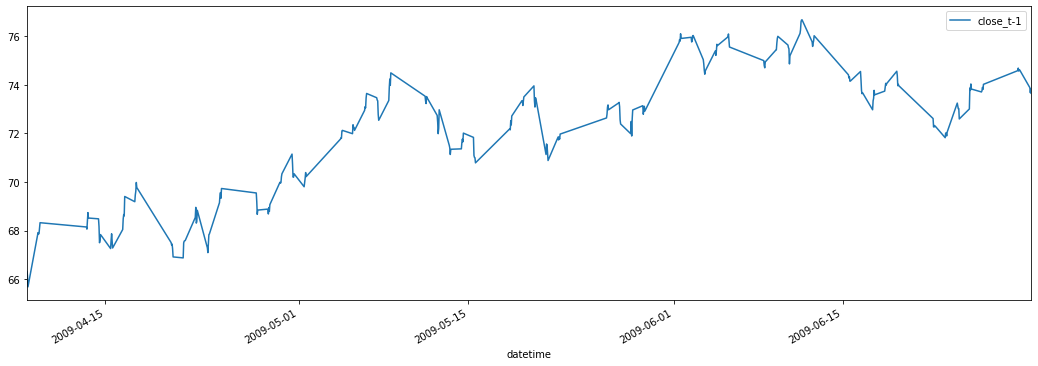

Number of instances: 287
Class distribution: 
0 in 0.4529616724738676%
1 in 0.5470383275261324%


<IPython.core.display.Javascript object>

Start spy_mahab_08-09_state_3_filling_gaps_market_hours_21.csv
              datetime     open     high      low    close     volume
0  2009-10-01 09:31:00  85.1632  85.2037  85.0904  85.0985  1099090.0
1  2009-10-01 09:32:00  85.0985  85.1470  85.0338  85.0661  1324020.0
2  2009-10-01 09:33:00  85.0661  85.0985  85.0338  85.0580   639264.0
3  2009-10-01 09:34:00  85.0661  85.1228  85.0257  85.0580  1541750.0
4  2009-10-01 09:35:00  85.0580  85.0661  84.7424  84.7748  3616010.0
             datetime     open     high      low    close     volume  \
0 2009-10-01 10:05:00  84.5725  84.6372  84.4026  84.4268  2207180.0   
1 2009-10-01 10:06:00  84.4187  84.4592  84.3216  84.4026  3072900.0   
2 2009-10-01 10:07:00  84.4026  84.4430  84.2812  84.3702  1644280.0   
3 2009-10-01 10:08:00  84.3702  84.4754  84.2812  84.4511  2309230.0   
4 2009-10-01 10:09:00  84.4592  84.4592  84.3378  84.3459  2092700.0   

   close_t-1  close_t-2  close_t-3  close_t-4  ...     sar_10    ppo_10  \
0    84.5

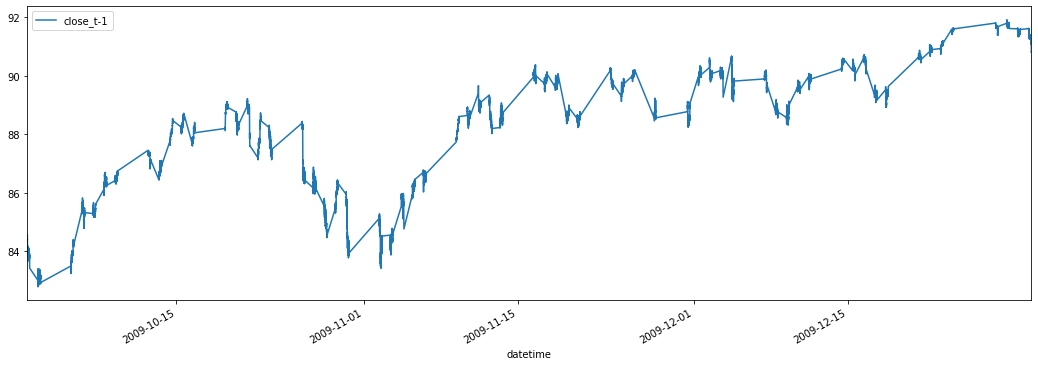

Number of instances: 22656
Class distribution: 
0 in 0.5801995056497176%
1 in 0.4198004943502825%


<IPython.core.display.Javascript object>

Start spy_mahab_08-09_state_3_filling_gaps_market_hours_21.csv
              datetime     open     high      low    close     volume
0  2009-10-01 09:35:00  85.0580  85.0661  84.7424  84.9124  7311712.0
1  2009-10-01 09:40:00  84.9124  84.9690  84.8315  84.9366  4910944.0
2  2009-10-01 09:45:00  84.9286  85.0499  84.8638  85.0338  4898785.0
3  2009-10-01 09:50:00  85.0418  85.0418  84.8072  84.8638  5507797.0
4  2009-10-01 09:55:00  84.8638  84.9609  84.8072  84.9528  4017781.0
             datetime     open     high      low    close     volume  \
0 2009-10-01 12:20:00  84.0708  84.1841  84.0627  84.1517  1671058.0   
1 2009-10-01 12:25:00  84.1517  84.1598  84.0870  84.1355  1562317.8   
2 2009-10-01 12:30:00  84.1274  84.1922  84.1193  84.1679  1219541.0   
3 2009-10-01 12:35:00  84.1598  84.1841  84.0789  84.0789   865999.1   
4 2009-10-01 12:40:00  84.0870  84.1112  84.0222  84.0384   867590.8   

   close_t-1  close_t-2  close_t-3  close_t-4  ...     sar_10    ppo_10  \
0    84.0

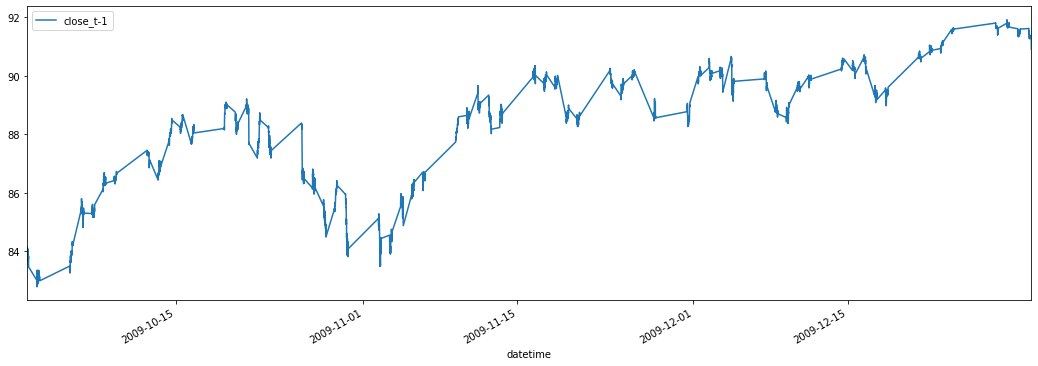

Number of instances: 4516
Class distribution: 
0 in 0.5338795394154119%
1 in 0.4661204605845881%


<IPython.core.display.Javascript object>

Start spy_mahab_08-09_state_3_filling_gaps_market_hours_21.csv
              datetime     open     high      low    close      volume
0  2009-10-01 09:40:00  84.9124  85.0499  84.8315  85.0338   9809729.0
1  2009-10-01 09:50:00  85.0418  85.0418  84.8072  84.9528   9525578.0
2  2009-10-01 10:00:00  84.9043  85.1956  84.0060  84.3459  31893620.0
3  2009-10-01 10:10:00  84.3459  84.4997  84.2812  84.4430  10193724.0
4  2009-10-01 10:20:00  84.4430  84.5482  84.3621  84.4026   6427022.0
             datetime     open     high      low    close      volume  \
0 2009-10-01 15:10:00  83.7633  83.8927  83.7309  83.8604   3815998.0   
1 2009-10-01 15:20:00  83.8604  83.8766  83.6985  83.7471   8477351.0   
2 2009-10-01 15:30:00  83.7390  83.9008  83.7228  83.8280   6694142.0   
3 2009-10-01 15:40:00  83.8199  83.9656  83.7471  83.8037   6930544.0   
4 2009-10-01 15:50:00  83.8037  83.8118  83.3101  83.3425  26594250.0   

   close_t-1  close_t-2  close_t-3  close_t-4  ...     sar_10    ppo_10 

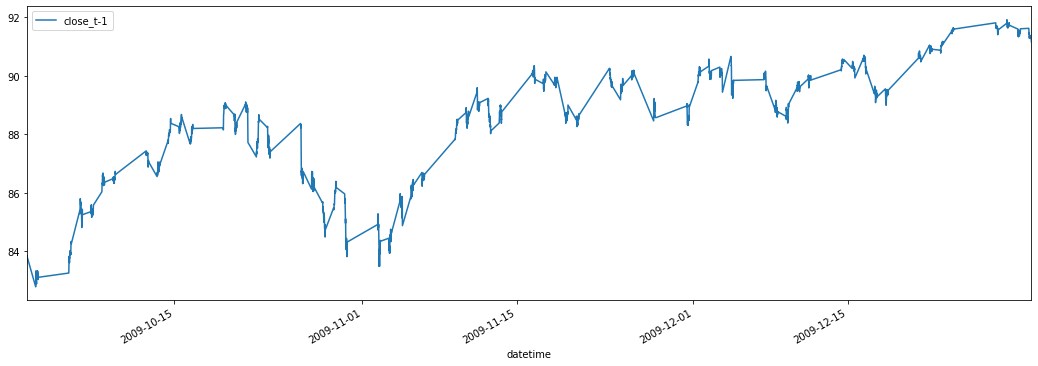

Number of instances: 2209
Class distribution: 
0 in 0.5151652331371661%
1 in 0.4848347668628339%


<IPython.core.display.Javascript object>

Start spy_mahab_08-09_state_3_filling_gaps_market_hours_21.csv
              datetime     open     high      low    close      volume
0  2009-10-01 09:45:00  84.9286  85.0499  84.8072  84.9528  14424363.0
1  2009-10-01 10:00:00  84.9043  85.1956  84.0060  84.4511  37215495.0
2  2009-10-01 10:15:00  84.4430  84.5482  84.2974  84.4026  11298871.0
3  2009-10-01 10:30:00  84.4026  84.6130  84.3055  84.5320   7983153.0
4  2009-10-01 10:45:00  84.5320  84.5644  84.3540  84.4268   7035694.7
             datetime     open     high      low    close     volume  \
0 2009-10-02 11:45:00  82.9055  83.0269  82.8326  82.8893  5507598.0   
1 2009-10-02 12:00:00  82.8812  83.1563  82.8731  83.0107  5243705.0   
2 2009-10-02 12:15:00  83.0107  83.2130  83.0107  83.1806  3983801.0   
3 2009-10-02 12:30:00  83.1887  83.2858  83.0673  83.0997  5722013.8   
4 2009-10-02 12:45:00  83.0916  83.2130  83.0107  83.1725  4219989.5   

   close_t-1  close_t-2  close_t-3  close_t-4  ...     sar_10    ppo_10  \
0  

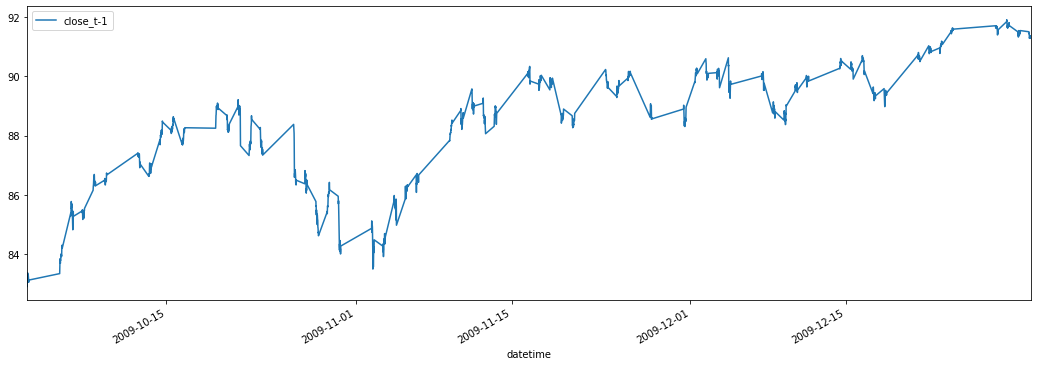

Number of instances: 1442
Class distribution: 
0 in 0.507628294036061%
1 in 0.492371705963939%


<IPython.core.display.Javascript object>

Start spy_mahab_08-09_state_3_filling_gaps_market_hours_21.csv
              datetime     open     high      low    close      volume
0  2009-10-01 10:00:00  84.9043  85.1956  84.0060  84.4026  48514366.0
1  2009-10-01 10:30:00  84.4026  84.6130  84.3055  84.4268  15018847.7
2  2009-10-01 11:00:00  84.4349  84.4430  83.8685  83.9413  26616278.0
3  2009-10-01 11:30:00  83.9413  84.0627  83.8604  84.0141  14046438.0
4  2009-10-01 12:00:00  84.0222  84.1841  83.8766  84.1355   9900379.8
             datetime     open     high      low    close      volume  \
0 2009-10-05 14:30:00  83.9494  84.4187  83.9494  84.2893  16012790.2   
1 2009-10-05 15:00:00  84.2893  84.3702  84.2326  84.2893  11291548.0   
2 2009-10-05 15:30:00  84.2893  84.3216  84.1274  84.1841  20860529.0   
3 2009-10-06 10:30:00  85.2846  85.5759  85.2684  85.5355  12296154.5   
4 2009-10-06 11:00:00  85.5274  85.8673  85.4869  85.6973  16922767.6   

   close_t-1  close_t-2  close_t-3  close_t-4  ...     sar_10    ppo_10 

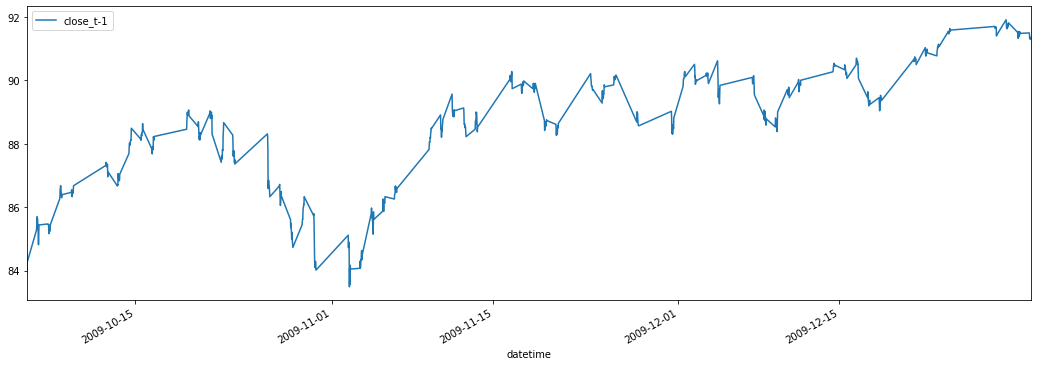

Number of instances: 673
Class distribution: 
0 in 0.5185735512630015%
1 in 0.4814264487369985%


<IPython.core.display.Javascript object>

Start spy_mahab_08-09_state_3_filling_gaps_market_hours_21.csv
              datetime     open     high      low    close      volume
0  2009-10-01 10:00:00  84.9043  85.1956  84.0060  84.4268  63533213.7
1  2009-10-01 11:00:00  84.4349  84.4430  83.8604  84.0141  40662716.0
2  2009-10-01 12:00:00  84.0222  84.1922  83.8766  84.0384  16832334.2
3  2009-10-01 13:00:00  84.0384  84.0546  83.6419  83.8927  30415849.6
4  2009-10-01 14:00:00  83.8847  84.1193  83.7794  83.8927  24283978.2
             datetime     open     high      low    close      volume  \
0 2009-10-08 13:00:00  86.6360  86.6441  86.2314  86.4580  23587932.6   
1 2009-10-08 14:00:00  86.4661  86.4823  86.1829  86.3609  17968975.4   
2 2009-10-08 15:00:00  86.3609  86.5713  86.1910  86.2719  42062571.0   
3 2009-10-09 11:00:00  86.4985  86.6117  86.4094  86.4337  22190212.3   
4 2009-10-09 12:00:00  86.4337  86.5066  86.2881  86.4580  13108695.8   

   close_t-1  close_t-2  close_t-3  close_t-4  ...     sar_10    ppo_10 

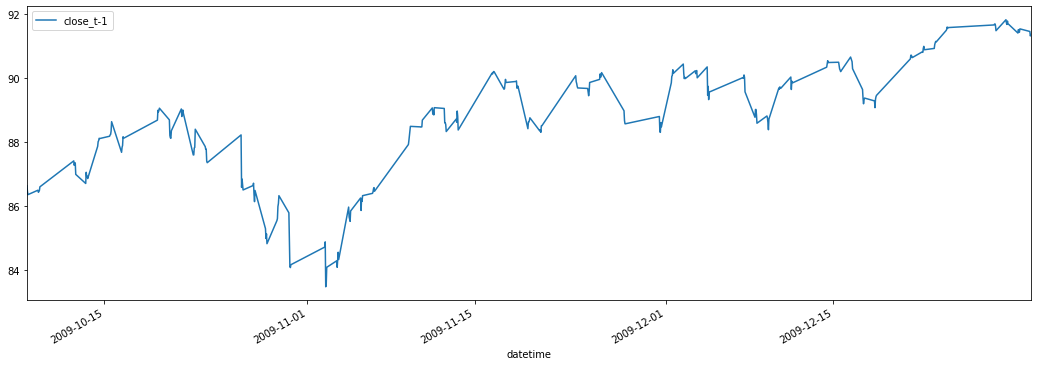

Number of instances: 292
Class distribution: 
0 in 0.4691780821917808%
1 in 0.5308219178082192%


<IPython.core.display.Javascript object>

Start spy_devset_2010_filling_gaps_market_hours_21.csv
              datetime     open     high      low    close     volume
0  2010-01-04 09:31:00  91.4633  91.5202  91.4470  91.4877  1575630.0
1  2010-01-04 09:32:00  91.4877  91.4958  91.4552  91.4877   910577.0
2  2010-01-04 09:33:00  91.4958  91.4958  91.4552  91.4552  1227660.0
3  2010-01-04 09:34:00  91.4552  91.4714  91.4470  91.4714   609509.0
4  2010-01-04 09:35:00  91.4633  91.6016  91.4633  91.5935  1925110.0
             datetime     open     high      low    close    volume  \
0 2010-01-04 10:05:00  91.7318  91.8294  91.7236  91.8213  858800.0   
1 2010-01-04 10:06:00  91.8294  91.8538  91.8131  91.8538  370892.0   
2 2010-01-04 10:07:00  91.8457  91.8782  91.8294  91.8294  385176.0   
3 2010-01-04 10:08:00  91.8294  91.8701  91.8131  91.8131  387669.0   
4 2010-01-04 10:09:00  91.8213  91.8782  91.8213  91.8782  284207.0   

   close_t-1  close_t-2  close_t-3  close_t-4  ...     sar_10    ppo_10  \
0    91.7318    91.8294

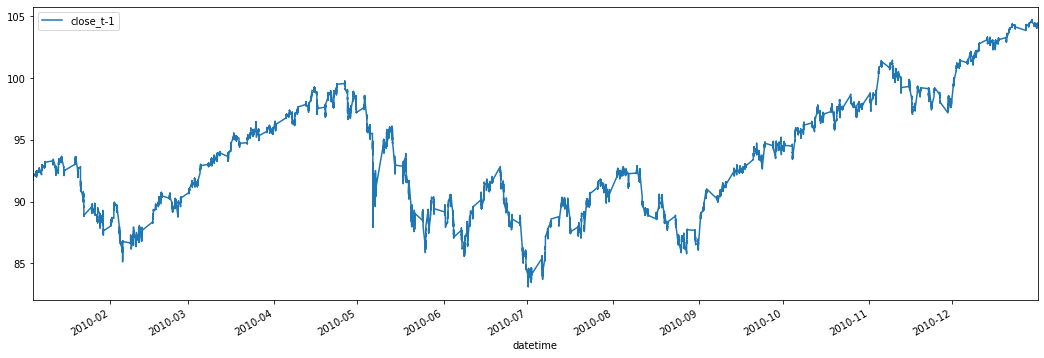

Number of instances: 89208
Class distribution: 
0 in 0.5606223657071114%
1 in 0.4393776342928885%


<IPython.core.display.Javascript object>

Start spy_devset_2010_filling_gaps_market_hours_21.csv
              datetime     open     high      low    close     volume
0  2010-01-04 09:35:00  91.4633  91.6830  91.4633  91.6423  5384792.0
1  2010-01-04 09:40:00  91.6504  91.7318  91.6423  91.7155  3536730.0
2  2010-01-04 09:45:00  91.7155  91.8864  91.6830  91.8864  5355208.0
3  2010-01-04 09:50:00  91.8782  91.8864  91.7480  91.7887  3617526.0
4  2010-01-04 09:55:00  91.7887  91.8213  91.7318  91.7969  2321085.0
             datetime     open     high      low    close     volume  \
0 2010-01-04 12:20:00  92.1467  92.1792  92.1386  92.1630   779264.6   
1 2010-01-04 12:25:00  92.1711  92.1874  92.1548  92.1792   604726.5   
2 2010-01-04 12:30:00  92.1792  92.1874  92.1711  92.1874   309085.8   
3 2010-01-04 12:35:00  92.1874  92.2199  92.1711  92.1792  1012131.0   
4 2010-01-04 12:40:00  92.1874  92.2118  92.1548  92.1955   643233.1   

   close_t-1  close_t-2  close_t-3  close_t-4  ...     sar_10    ppo_10  \
0    92.1386    9

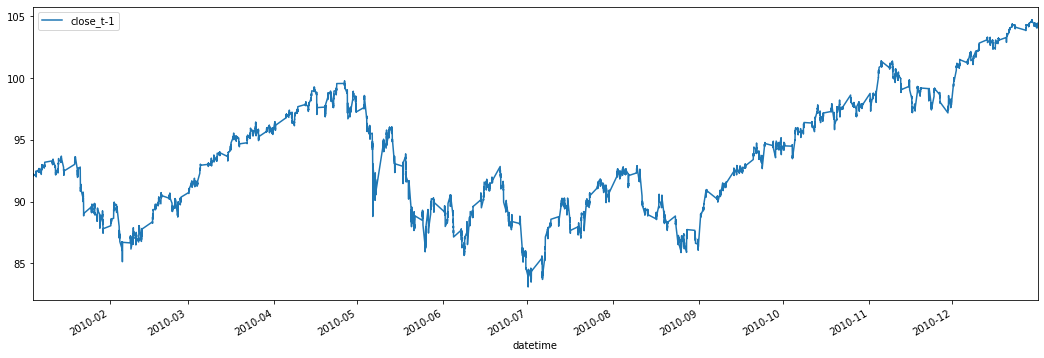

Number of instances: 17864
Class distribution: 
0 in 0.5184729064039408%
1 in 0.4815270935960591%


<IPython.core.display.Javascript object>

Start spy_devset_2010_filling_gaps_market_hours_21.csv
              datetime     open     high      low    close     volume
0  2010-01-04 09:40:00  91.6504  91.8864  91.6423  91.8864  8891938.0
1  2010-01-04 09:50:00  91.8782  91.8864  91.7318  91.7969  5938611.0
2  2010-01-04 10:00:00  91.8050  91.9026  91.7155  91.8782  7878538.0
3  2010-01-04 10:10:00  91.8701  91.8782  91.7887  91.8213  3096548.0
4  2010-01-04 10:20:00  91.8213  92.0165  91.8050  92.0084  4446739.0
             datetime     open     high      low    close     volume  \
0 2010-01-04 15:10:00  92.2199  92.2281  92.1630  92.1792  1775145.9   
1 2010-01-04 15:20:00  92.1792  92.1874  92.1304  92.1467  1719545.3   
2 2010-01-04 15:30:00  92.1386  92.1711  92.0897  92.0897  3238517.9   
3 2010-01-04 15:40:00  92.0979  92.1955  92.0816  92.1955  4617691.0   
4 2010-01-04 15:50:00  92.1955  92.1955  92.1142  92.1955  9876571.0   

   close_t-1  close_t-2  close_t-3  close_t-4  ...     sar_10    ppo_10  \
0    92.2199    9

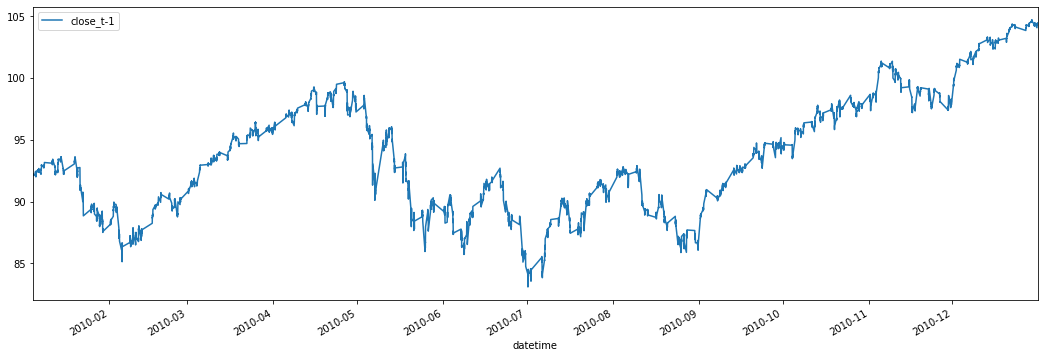

Number of instances: 8789
Class distribution: 
0 in 0.5046080327682331%
1 in 0.495391967231767%


<IPython.core.display.Javascript object>

Start spy_devset_2010_filling_gaps_market_hours_21.csv
              datetime     open     high      low    close      volume
0  2010-01-04 09:45:00  91.7155  91.8864  91.6830  91.7969  11293819.0
1  2010-01-04 10:00:00  91.8050  91.9026  91.7155  91.8538   9559761.0
2  2010-01-04 10:15:00  91.8619  92.0165  91.8050  92.0084   5862064.0
3  2010-01-04 10:30:00  92.0003  92.0816  91.9840  92.0816   6069863.7
4  2010-01-04 10:45:00  92.0816  92.1304  92.0084  92.0165   4322844.4
             datetime     open     high      low    close     volume  \
0 2010-01-05 11:45:00  92.1955  92.2362  92.1955  92.2199  3501877.5   
1 2010-01-05 12:00:00  92.2281  92.3420  92.2199  92.3420  2534880.7   
2 2010-01-05 12:15:00  92.3338  92.3420  92.2606  92.2606  2698641.4   
3 2010-01-05 12:30:00  92.2687  92.2769  92.2362  92.2525  2026552.7   
4 2010-01-05 12:45:00  92.2525  92.2606  92.1548  92.2199  2051990.5   

   close_t-1  close_t-2  close_t-3  close_t-4  ...     sar_10    ppo_10  \
0    92.195

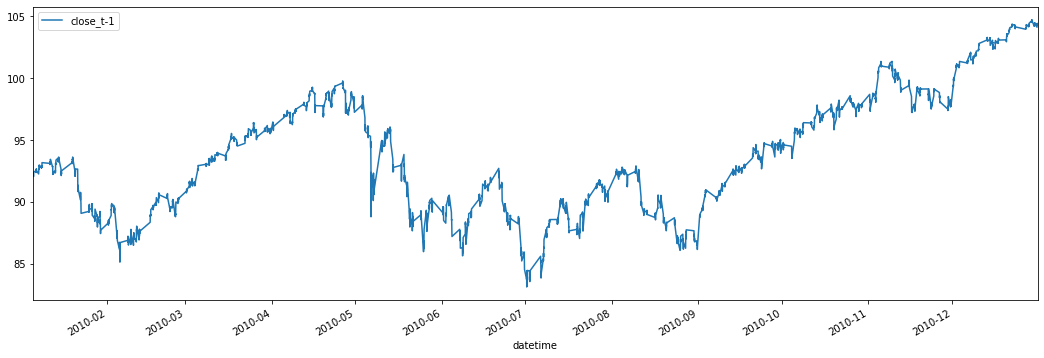

Number of instances: 5766
Class distribution: 
0 in 0.49791883454734653%
1 in 0.5020811654526535%


<IPython.core.display.Javascript object>

Start spy_devset_2010_filling_gaps_market_hours_21.csv
              datetime     open     high      low    close      volume
0  2010-01-04 10:00:00  91.8050  92.0165  91.7155  92.0084  15421825.0
1  2010-01-04 10:30:00  92.0003  92.1304  91.9840  92.0165  10392708.1
2  2010-01-04 11:00:00  92.0165  92.1711  92.0165  92.1223   6983607.0
3  2010-01-04 11:30:00  92.1142  92.2525  92.0979  92.1630   7472627.2
4  2010-01-04 12:00:00  92.1630  92.1874  92.1386  92.1792   4423029.0
             datetime     open     high      low    close      volume  \
0 2010-01-06 14:30:00  92.5860  92.7406  92.5779  92.6674   8677951.7   
1 2010-01-06 15:00:00  92.6674  92.6918  92.5291  92.6023   7703751.8   
2 2010-01-06 15:30:00  92.5942  92.6593  92.4314  92.5372  16328217.1   
3 2010-01-07 10:30:00  92.3176  92.6837  92.2769  92.5942  16685491.7   
4 2010-01-07 11:00:00  92.5942  92.6430  92.5616  92.5616   5953549.9   

   close_t-1  close_t-2  close_t-3  close_t-4  ...     sar_10    ppo_10  \
0    

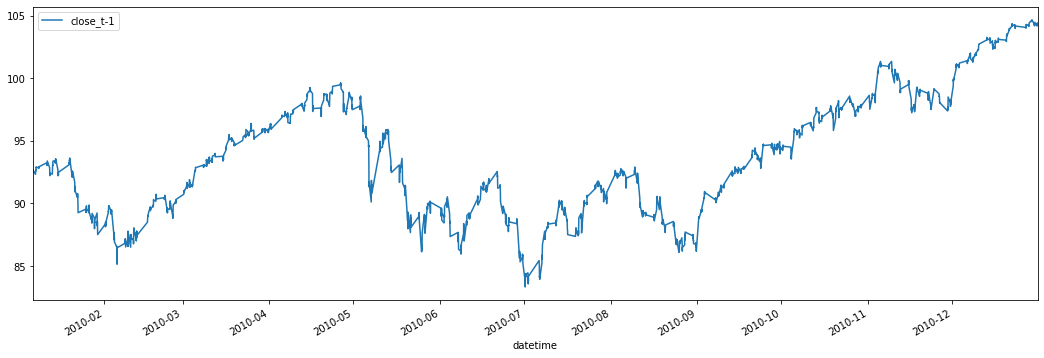

Number of instances: 2741
Class distribution: 
0 in 0.4848595403137541%
1 in 0.5151404596862459%


<IPython.core.display.Javascript object>

Start spy_devset_2010_filling_gaps_market_hours_21.csv
              datetime     open     high      low    close      volume
0  2010-01-04 10:00:00  91.8050  92.1304  91.7155  92.0165  25814533.1
1  2010-01-04 11:00:00  92.0165  92.2525  92.0165  92.1630  14456234.2
2  2010-01-04 12:00:00  92.1630  92.2281  92.1386  92.1792   8212385.3
3  2010-01-04 13:00:00  92.2037  92.2443  92.0735  92.0897   8767227.0
4  2010-01-04 14:00:00  92.0979  92.2443  92.0735  92.1630   8978854.5
             datetime     open     high      low    close      volume  \
0 2010-01-11 13:00:00  93.0416  93.1881  92.9928  93.1637   8874288.2   
1 2010-01-11 14:00:00  93.1637  93.2288  93.0823  93.1881  10974788.0   
2 2010-01-11 15:00:00  93.1718  93.4484  93.1718  93.3427  26081180.0   
3 2010-01-12 11:00:00  92.8464  92.8871  92.6430  92.6674  18842589.7   
4 2010-01-12 12:00:00  92.6593  92.6674  92.1711  92.2118  29525661.0   

   close_t-1  close_t-2  close_t-3  close_t-4  ...     sar_10    ppo_10  \
0    

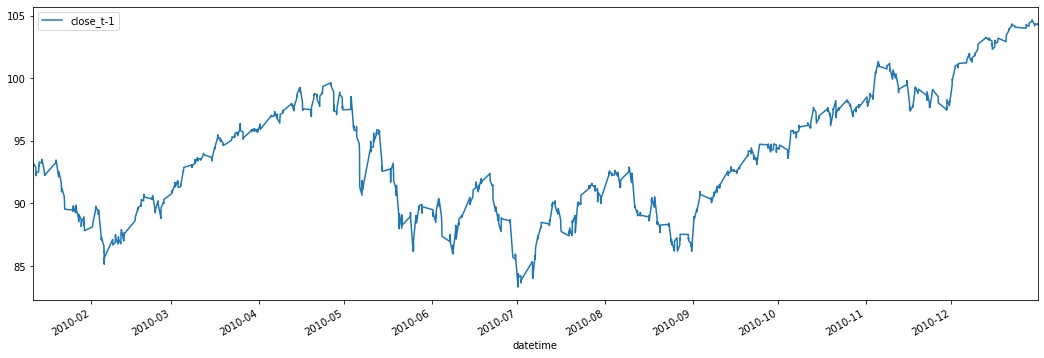

Number of instances: 1232
Class distribution: 
0 in 0.45616883116883117%
1 in 0.5438311688311688%


<IPython.core.display.Javascript object>

Start spy_trainset_2011-2020_filling_gaps_market_hours_21.csv
              datetime     open     high      low    close     volume
0  2011-01-03 09:31:00  105.122  105.180  105.097  105.180  1039570.0
1  2011-01-03 09:32:00  105.180  105.197  105.130  105.147   727576.0
2  2011-01-03 09:33:00  105.147  105.188  105.130  105.138   554285.0
3  2011-01-03 09:34:00  105.138  105.155  105.130  105.155   751152.0
4  2011-01-03 09:35:00  105.147  105.172  105.138  105.147   674601.0
             datetime     open     high      low    close    volume  \
0 2011-01-03 10:05:00  105.387  105.412  105.387  105.396  390012.0   
1 2011-01-03 10:06:00  105.396  105.412  105.379  105.387  366656.0   
2 2011-01-03 10:07:00  105.387  105.429  105.371  105.396  691340.0   
3 2011-01-03 10:08:00  105.387  105.396  105.371  105.371  274239.0   
4 2011-01-03 10:09:00  105.379  105.412  105.379  105.412  198760.0   

   close_t-1  close_t-2  close_t-3  close_t-4  ...      sar_10    ppo_10  \
0    105.387   

In [ ]:
# BATCH

# Paths for symbols
# DATA_PATH=os.sep.join(['C:','Users','suare','PycharmProjects','RegimeSwitchingSeriesGenerator','data'])
# SOURCE_PATH=DATA_PATH 
RESULT_PATH=os.sep.join(['C:','Users','suare','PycharmProjects','RegimeSwitchingSeriesGenerator','output']) 

modes = ['indicators_best', 'indicators_best_and_times', 'indicators_fullset']
# sets = ['mahalanobis', 'dev', 'train'] #'mahalanobis', 'dev'] #, 'train']  # dates hardcoded later.

for mode in modes:
    for file in files_for_indicators:
#         for dataset in sets:
#           filename = file.replace(SOURCE_PATH+os.sep,'')
            filename = file.split(os.sep)[-1]
            FIELD = 'close' # price->'ts' returns->'ret_ts' ts_with_added_noise-> 'ts_n2_post'
            print(f'Start {filename}')

#             file = os.sep.join([SOURCE_PATH, filename])
    #         RESULT_FILEPATH_PROCESSED = os.sep.join([RESULT_PATH, filename.split(os.sep)[-1].replace('.csv','')+'_'+level+f'_indicators_best_no_filling_gaps_{dataset}_05062020.csv'])
#             RESULT_FILEPATH_PROCESSED = os.sep.join([RESULT_PATH, filename.split(os.sep)[-1].replace('.csv','')+'_'+level+f'{dataset}_{mode}_23062020.csv'])
#             RESULT_FILEPATH_PROCESSED = os.sep.join([RESULT_PATH, filename.split(os.sep)[-1].replace('.csv','')+'_'+level+f'{dataset}_{mode}_recession_2001.csv'])
#             RESULT_FILEPATH_PROCESSED = os.sep.join([RESULT_PATH, filename.split(os.sep)[-1].replace('.csv','')+'_'+level+f'{dataset}_{mode}_great_recession.csv'])
            RESULT_FILEPATH_PROCESSED = os.sep.join([RESULT_PATH, filename.split(os.sep)[-1].replace('.csv','')+'_'+level+f'{mode}.csv'])

            # Open file
            df=pd.read_csv(file, sep=';')

#             # Get date range for the current set (TODO: add to adict so if else conditions are not required and can be soecufued at the start)
#             if dataset == 'mahalanobis':
#                 # 1998
#                 # df = df[df.datetime.astype('str') <= '1998-12-31 16:00:00']  # Mahalanobis Set
#                 # 2000
# #                 df = df[(df.datetime.astype('str') > '1999-12-31 16:00:00') & (df.datetime.astype('str') <= '2000-12-31 16:00:00')]
#                 # 2007
#                 df = df[(df.datetime.astype('str') > '2006-12-31 16:00:00') & (df.datetime.astype('str') <= '2007-12-31 16:00:00')]
#             elif dataset == 'dev':
#                 # 1999
#                 # df = df[(df.datetime.astype('str') > '1998-12-31 16:00:00') & (df.datetime.astype('str') <= '1999-12-31 16:00:00')]
#                 # 2001
# #                 df = df[(df.datetime.astype('str') > '2000-12-31 16:00:00') & (df.datetime.astype('str') <= '2001-12-31 16:00:00')]
#                 # 2008
#                 df = df[(df.datetime.astype('str') > '2007-12-31 16:00:00') & (df.datetime.astype('str') <= '2008-12-31 16:00:00')]
#             elif dataset == 'train': 
#                 # 2000-2020/05
# #               df = df[df.datetime.astype('str') > '1999-12-31 16:00:00']
#                 # 2002-2020/05
# #                 df = df[df.datetime.astype('str') > '2001-12-31 16:00:00']
#                 # 2009-2020/05
#                 df = df[df.datetime.astype('str') > '2008-12-31 16:00:00']
#             else:
#                 assert False, 'please, add a proper set name. either Mahalanobis, dev or train.'


            print(df.head())
    #         assert False
            df=df.drop_duplicates(['datetime','open','high','low','close','volume']) 

            #Add parameters to transform in TS
            timeseries=['close', 'open', 'high', 'low']
            #Length of the TS. How many values do we keep per serie. 
            # e.g. 1 -> t / 2 -> t,t-1 / 3 -> t,t-1,t-2 / 4 -> t,t-1,t-2,t-3
            length = 5

            # Add lagged times
            for column in timeseries:
                for i in range(1,length):
                    df[column+'_t-'+str(i)]=df[column].shift(i) #it could also be sorted and group by if needed


            # all the numbers here and below assume a default time period for ta params of 10 mins averages
            # change the other numbers (params of 5min and 20min and theremoval of 20 first mins of the day below) if the mins number is changed.
            # in that case change as well the time tag '_10' with the corresponding one.
            default_timerange=10
            # Set extra timeranges for moving averages
            extra_timeranges=[default_timerange//2, default_timerange, default_timerange*2, default_timerange*3]

            # ###########################################
            # Iterate and run list of indicators selected
            # All of them produced for 25 prior mins of data 
            # ###########################################    
            for ind in list(indicators):
#                 print(ind)
                if ind not in ['adosc', 'obv', 'mfi']:  # avoiding indicators that need volume
                    # For indicators that only return one column (this will need to be modified depending on the selection of indicators)
                    if ind in ['ema','sma','trima']:
                        for timerange in extra_timeranges:
#                             print(ind+'_'+str(int(timerange)))
                            df[ind+'_'+str(int(timerange))] = get_indicator(ind)(df, timeperiod=timerange) 
                    elif ind not in ['bbands','aroon','stoch','macd','macdfix','stochf']:
                        df[ind+'_'+str(int(default_timerange))] = get_indicator(ind)(df, timeperiod=(default_timerange))
                    # Otherwise check the list of columns and return all
                    else: 
                        key_output=get_indicator(ind)(df, timeperiod=(default_timerange)) #, price='close')
                        for j in range(0,len(list(key_output.columns))):
                            df[ind+'_'+key_output.columns[int(j)]] = key_output[key_output.columns[j]]
        #     for key in list(indicator.keys()):
        #         # For indicators that only return one column (this will need to be modified depending on the selection of indicators)
        #         if key in ['ema','sma','trima']:
        #             df[key+'_'+str(default_timerange//2)]=indicator[key](df, timeperiod=(default_timerange/2)) 
        #             df[key+'_'+str(default_timerange)]=indicator[key](df, timeperiod=(default_timerange)) 
        #             df[key+'_'+str(default_timerange*2)]=indicator[key](df, timeperiod=(default_timerange*2))     
        #         elif key not in ['bbands','aroon','stoch','macd','macdfix','stochf']:
        #             df[key+'_'+str(default_timerange)]=indicator[key](df, timeperiod=(default_timerange))
        #         # Otherwise check the list of columns and return all
        #         else: 
        #             key_output=indicator[key](df, timeperiod=(default_timerange)) #, price='close')
        #             for j in range(0,len(list(key_output.columns))):
        #                 df[key+'_'+key_output.columns[j]] = key_output[key_output.columns[j]]

            def set_label(row):
                if row['close_t+1'] > row['close']: return 1
                else: return 0

            # One minute ahead closing price
            df['close_t+1']=df['close'].shift(-1)
        #     df['close_t+1']=df['close'].shift(-1)

        #     def func(row):
        #         if row['close_t+1'] > row['close']:
        #             return 1
        #         else:
        #             return 0

            # Creating label/y to be predicted / independent (predicted) feature 'y' 
            df['label'] = df.apply(set_label, axis=1)
        #     df['label'] = df.apply(func, axis=1)

            df.dropna(inplace=True)

            # Encoding cyclical continuous features for the trading day (6.5h a day except for shortened sessions)
            start_market = 34200.0 # 9:30am
            end_market = 57600.0 # 04:00pm
            df['seconds'] = (pd.to_datetime(df.datetime) - pd.to_datetime(df.datetime.str[:10])).dt.total_seconds() - start_market
            seconds_trading_day = end_market - start_market  # specific to US EFTs, and not considering shortened trading sessions (2 per year).
            df['sin_time'] = np.sin(2*np.pi*df.seconds/seconds_trading_day)
            df['cos_time'] = np.cos(2*np.pi*df.seconds/seconds_trading_day)
        #     df.cos_time.plot(figsize=(15,6))
        #     df.sample(50).plot.scatter('sin_time','cos_time').set_aspect('equal');

            # Day of the week (cyclical also, for weeks of 5 days)
            df['dow'] = pd.to_datetime(df.datetime).dt.dayofweek
            df['sin_dow'] = np.sin(2*np.pi*df.dow/5)
            df['cos_dow'] = np.cos(2*np.pi*df.dow/5)
        #     df.cos_dow.plot(figsize=(15,6))
        #     df.sample(50).plot.scatter('sin_dow','cos_dow').set_aspect('equal');

            # Select columns for output
            if mode == 'indicators_best':
                # best pool found through indicators grid search script
                columns_selected = ['rsi_10','willr_10','macd_macd','cci_10','mom_10','stoch_slowk','stoch_slowd',
                                    'sma_5','sma_10', 'wma_10','ema_10','trima_10','adx_10',
                                    'bbands_upperband','bbands_lowerband','roc_10', 'aroon_aroondown','aroon_aroonup', 
                                    'label']
            elif mode == 'indicators_best_and_times':
                columns_selected = ['rsi_10','willr_10','macd_macd','cci_10','mom_10','stoch_slowk','stoch_slowd',
                                    'sma_5','sma_10', 'wma_10','ema_10','trima_10','adx_10',
                                    'bbands_upperband','bbands_lowerband','roc_10', 'aroon_aroondown','aroon_aroonup', 
                                    'cos_time', 'cos_dow', 'label']
    #         columns_selected = ['rsi_10','willr_10','macd_macd','cci_10','mom_10','stoch_slowk','stoch_slowd','sma_5','sma_10',
    #                             'wma_10','ema_10','trima_10','adx_10','bbands_upperband','bbands_lowerband','roc_10',
    #                             'aroon_aroondown','aroon_aroonup', 'cos_time', 'cos_dow', 'dividends', 'label']
            elif mode == 'indicators_fullset':
                columns_selected=[# 'datetime',
                                 'rsi_10','willr_10','macd_macd' ,'cci_10','mom_10',
                                 'stoch_slowk','stoch_slowd',
                                 'sma_5','sma_10','sma_20','sma_30',
                                 'wma_5','wma_10','wma_20','wma_30',
                                 'ema_5','ema_10','ema_20','ema_30',
                                 'trima_5','trima_10','trima_20','trima_30',
                                 'adx_10','bbands_upperband','bbands_middleband','bbands_lowerband',
                                 'roc_10','rocr_10','stochf_fastd','stochf_fastk',
                                 'aroon_aroondown','aroon_aroonup','medprice_10','typprice_10','wclprice_10',
                                 'atr_10','macdfix_macd','sar_10',
                                 'adosc_10', 'obv_10', 'mfi_10', 'ppo_10', ########## commented out previosly
                                 'volume','volume_t-1','volume_t-2','volume_t-3','volume_t-4',
                                 'close','close_t-1','close_t-2','close_t-3','close_t-4',
                                 'high','high_t-1','high_t-2','high_t-3','high_t-4',
                                 'open','open_t-1','open_t-2','open_t-3','open_t-4',
                                 'low','low_t-1','low_t-2','low_t-3','low_t-4',
                                 'cos_time', 'sin_time', 'cos_dow', 'sin_dow',
        #                          # 'binary_label',
                                 'label'] #,'gap_t+1','close_t+1'] # + ['adosc_10', 'obv_10', 'mfi_10', 'ppo_10']
        #     columns_selected = ['datetime', 'sma_5','ema_5','sma_20','ema_20','adosc_10','macd_macd','willr_10','stoch_slowk','stoch_slowd','cci_10','ema_10','rsi_10','sma_10','mom_10', 'label']

            # indicators have dependendies up to 45 mins before. removing records that may look at pre-market or at the previous date
            df.datetime = pd.to_datetime(df.datetime)
            df.set_index('datetime', drop=True, inplace=True)
            df = df.between_time('10:05','15:58').reset_index()

            # Export processed data
            print(df.head())
            print(len(df))
            print(RESULT_FILEPATH_PROCESSED)
            print('===========================')
            print('===========================')
            output = pd.DataFrame(df, columns=columns_selected) # [df['datetime'] >= '2017-09-25 14:07:00']
            output.to_csv(RESULT_FILEPATH_PROCESSED, sep=',', encoding='utf-8', index = False)
            devsets_path = 'C:\\Users\\suare\\Workspace\\phd_cetrulin\\moa-2017.06-sources\\data\\real\\spy_final_2021_staging_area\\'
        #     create_arff_file(RESULT_FILEPATH_PROCESSED) # export in ARFF
            create_arff_file(RESULT_FILEPATH_PROCESSED, output=devsets_path+RESULT_FILEPATH_PROCESSED.split(os.sep)[-1]) # export in ARFF
            
            # Now plot close price and volume overtime.
            df.set_index('datetime',drop=True).plot(y=["close_t-1"], figsize=(18,6))
            plt.show()    

            print(f'Number of instances: {len(df)}')
            # Printing classes distributions
            print("Class distribution: ")
            label_zero=len(df[df['label'] == 0])
            label_one=len(df[df['label'] == 1])
            #print(label_zero)
            #print(label_one)
            print("0 in "+str(float(label_zero)/(label_one+label_zero))+"%")
            print("1 in "+str(float(label_one)/(label_one+label_zero))+"%")

            %notify -m "Parsing is finished"

In [ ]:
C:\\Users\\suare\\PycharmProjects\\RegimeSwitchingSeriesGenerator\\data\\efts\\1h-level\\S&P500

In [ ]:
C:\\Users\\suare\\PycharmProjects\\RegimeSwitchingSeriesGenerator\\data\\spy_trainset_2011-2020.csv